In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import log_loss
%matplotlib inline

from nba_py import player
import webscrape

/Users/bumho/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
shot_chart_url = 'http://stats.nba.com/stats/shotchartdetail?Period=0&VsConference=&LeagueID=00&LastNGames=0&TeamID=0&Position=&Location=&Outcome=&ContextMeasure=FGA&DateFrom=&StartPeriod=&DateTo=&OpponentTeamID=0&ContextFilter=&RangeType=&Season=2015-16&AheadBehind=&PlayerID=201939&EndRange=&VsDivision=&PointDiff=&RookieYear=&GameSegment=&Month=0&ClutchTime=&StartRange=&EndPeriod=&SeasonType=Regular+Season&SeasonSegment=&GameID='
# Get the webpage containing the data
response = requests.get(shot_chart_url)
print response
# Grab the headers to be used as column headers for our DataFrame
headers = response.json()['resultSets'][0]['headers']
print headers
# Grab the shot chart data
shots = response.json()['resultSets'][0]['rowSet']

<Response [200]>
[u'GRID_TYPE', u'GAME_ID', u'GAME_EVENT_ID', u'PLAYER_ID', u'PLAYER_NAME', u'TEAM_ID', u'TEAM_NAME', u'PERIOD', u'MINUTES_REMAINING', u'SECONDS_REMAINING', u'EVENT_TYPE', u'ACTION_TYPE', u'SHOT_TYPE', u'SHOT_ZONE_BASIC', u'SHOT_ZONE_AREA', u'SHOT_ZONE_RANGE', u'SHOT_DISTANCE', u'LOC_X', u'LOC_Y', u'SHOT_ATTEMPTED_FLAG', u'SHOT_MADE_FLAG']


In [5]:
url = "http://stats.nba.com/stats/shotchartdetail?Period=0&VsConference=&LeagueID=00&LastNGames=0&TeamID=0&Position=&Location=&Outcome=&ContextMeasure=FGA&DateFrom=&StartPeriod=&DateTo=&OpponentTeamID=0&ContextFilter=&RangeType=&Season=2013-14&AheadBehind=&PlayerID=201939&EndRange=&VsDivision=&PointDiff=&RookieYear=&GameSegment=&Month=0&ClutchTime=&StartRange=&EndPeriod=&SeasonType=Regular+Season&SeasonSegment=&GameID="
response = requests.get(url)
print response

<Response [400]>


In [6]:
shot_df = pd.DataFrame(shots, columns=headers)

In [7]:
def create_dataFrame(shot_chart_url):
    response = requests.get(shot_chart_url)
    # Grab the headers to be used as column headers for our DataFrame
    headers = response.json()['resultSets'][0]['headers']
    # Grab the shot chart data
    shots = response.json()['resultSets'][0]['rowSet']
    return pd.DataFrame(shots, columns=headers)
    

In [8]:
shot_df = create_dataFrame(shot_chart_url)
shot_df.columns

Index([u'GRID_TYPE', u'GAME_ID', u'GAME_EVENT_ID', u'PLAYER_ID',
       u'PLAYER_NAME', u'TEAM_ID', u'TEAM_NAME', u'PERIOD',
       u'MINUTES_REMAINING', u'SECONDS_REMAINING', u'EVENT_TYPE',
       u'ACTION_TYPE', u'SHOT_TYPE', u'SHOT_ZONE_BASIC', u'SHOT_ZONE_AREA',
       u'SHOT_ZONE_RANGE', u'SHOT_DISTANCE', u'LOC_X', u'LOC_Y',
       u'SHOT_ATTEMPTED_FLAG', u'SHOT_MADE_FLAG'],
      dtype='object')

In [9]:
def transform(data):
    action_type = pd.get_dummies(data.ACTION_TYPE)
    period = pd.get_dummies(data.PERIOD)
    shot_type = pd.get_dummies(data.SHOT_TYPE)
    shot_zone_basic = pd.get_dummies(data.SHOT_ZONE_BASIC)
    shot_zone_area = pd.get_dummies(data.SHOT_ZONE_AREA)
    shot_zone_range = pd.get_dummies(data.SHOT_ZONE_RANGE)

    new_shot_chart = pd.concat([action_type, period, shot_type, shot_zone_basic, shot_zone_area, shot_zone_range, data.SHOT_MADE_FLAG], axis=1)
    return new_shot_chart

In [10]:
new_shot_chart= transform(shot_df)

In [11]:
logistic = LogisticRegression()

In [12]:
def combine_years(year1, year2):
    combined = pd.concat([year1, year2])
    new_shot_chart_combined= transform(combined)
    predictors = new_shot_chart_combined.columns[:-1]
    return new_shot_chart_combined, predictors

In [13]:
def get_player_id(name):
    name = name.split(' ')
    return player.get_player(name[0], name[1], just_id=True)

def build_url(name, season):
    p_id = str(int(get_player_id(name)))
    url = "http://stats.nba.com/stats/shotchartdetail?Period=0&VsConference=&LeagueID=00&LastNGames=0&TeamID=0&Position=&Location=&Outcome=&ContextMeasure=FGA&DateFrom=&StartPeriod=&DateTo=&OpponentTeamID=0&ContextFilter=&RangeType=&Season="+season+"&AheadBehind=&PlayerID="+ p_id+"&EndRange=&VsDivision=&PointDiff=&RookieYear=&GameSegment=&Month=0&ClutchTime=&StartRange=&EndPeriod=&SeasonType=Regular+Season&SeasonSegment=&GameID="
    return url

In [17]:
athlete = "stephen curry"
season = "2014-15"
web_df = webscrape.getData(athlete, season[:-3])
print build_url(athlete, season)
api_df = create_dataFrame(build_url(athlete, season))

http://stats.nba.com/stats/shotchartdetail?Period=0&VsConference=&LeagueID=00&LastNGames=0&TeamID=0&Position=&Location=&Outcome=&ContextMeasure=FGA&DateFrom=&StartPeriod=&DateTo=&OpponentTeamID=0&ContextFilter=&RangeType=&Season=2014-15&AheadBehind=&PlayerID=201939&EndRange=&VsDivision=&PointDiff=&RookieYear=&GameSegment=&Month=0&ClutchTime=&StartRange=&EndPeriod=&SeasonType=Regular+Season&SeasonSegment=&GameID=


In [18]:
web_df

,Game Date,Player,Opp.,Q,Time,Shot Type,Shot Dist.,Made?,Drib.,Shot Clock,Touch Time,Defender,Def Dist.,,
0,2014-12-13,Stephen Curry,Dallas Mavericks,3,2:25,Driving Bank shot,5.20ft.,Yes,8,16.00,6.30,"Nowitzki, Dirk",3.20,\n\n\n,\n
1,2015-02-20,Stephen Curry,San Antonio Spurs,3,10:41,Driving Bank shot,13.60ft.,Yes,5,2.90,4.50,"Parker, Tony",1.70,\n\n\n,\n
2,2014-12-13,Stephen Curry,Dallas Mavericks,4,7:05,Driving Bank shot,6.00ft.,Yes,0,9.30,0.80,"Chandler, Tyson",3.70,\n\n\n,\n
3,2015-03-21,Stephen Curry,Utah Jazz,2,0:34,Driving Bank shot,9.00ft.,Yes,10,15.30,8.70,"Favors, Derrick",2.30,\n\n\n,\n
4,2015-04-04,Stephen Curry,Dallas Mavericks,1,11:23,Driving Bank shot,4.10ft.,Yes,0,20.80,0.80,"Nowitzki, Dirk",2.50,\n\n\n,\n
5,2015-03-21,Stephen Curry,Utah Jazz,4,1:56,Driving Finger Roll Layup Shot,4.40ft.,No,1,20.90,1.80,"Burke, Trey",3.80,\n\n\n,\n
6,2015-03-06,Stephen Curry,Dallas Mavericks,1,4:54,Driving Finger Roll Layup Shot,6.10ft.,No,3,21.00,2.90,"Chandler, Tyson",4.10,\n\n\n,\n
7,2015-03-23,Stephen Curry,Washington Wizards,2,2:07,Driving Finger Roll Layup Shot,6.20ft.,Yes,2,14.50,3.10,"Wall, John",0.30,\n\n\n,\n
8,2014-11-02,Stephen Curry,Portland Trail Blazers,2,2:47,Driving Finger Roll Layup Shot,6.10ft.,No,5,18.30,4.40,"Blake, Steve",2.70,\n\n\n,\n
9,2014-12-10,Stephen Curry,Houston Rockets,4,7:05,Driving Finger Roll Layup Shot,4.60ft.,Yes,14,13.60,10.50,"Harden, James",4.30,\n\n\n,\n


In [19]:
api_df

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG
0,Shot Chart Detail,0021400014,50,201939,Stephen Curry,1610612744,Golden State Warriors,1,7,29,...,Running Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,10,-81,72,1,1
1,Shot Chart Detail,0021400014,74,201939,Stephen Curry,1610612744,Golden State Warriors,1,5,9,...,Jump Shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,25,65,246,1,0
2,Shot Chart Detail,0021400014,176,201939,Stephen Curry,1610612744,Golden State Warriors,2,8,49,...,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,23,15,1,1
3,Shot Chart Detail,0021400014,205,201939,Stephen Curry,1610612744,Golden State Warriors,2,6,43,...,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,-11,7,1,1
4,Shot Chart Detail,0021400014,227,201939,Stephen Curry,1610612744,Golden State Warriors,2,5,36,...,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,24,-164,187,1,0
5,Shot Chart Detail,0021400014,238,201939,Stephen Curry,1610612744,Golden State Warriors,2,4,59,...,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,10,-4,102,1,0
6,Shot Chart Detail,0021400014,305,201939,Stephen Curry,1610612744,Golden State Warriors,2,1,6,...,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Left Side(L),8-16 ft.,8,-78,34,1,0
7,Shot Chart Detail,0021400014,349,201939,Stephen Curry,1610612744,Golden State Warriors,3,10,18,...,Jump Shot,3PT Field Goal,Left Corner 3,Left Side(L),24+ ft.,23,-229,26,1,0
8,Shot Chart Detail,0021400014,378,201939,Stephen Curry,1610612744,Golden State Warriors,3,8,2,...,Jump Shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,25,-54,246,1,0
9,Shot Chart Detail,0021400014,431,201939,Stephen Curry,1610612744,Golden State Warriors,3,4,26,...,Jump Shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,24,-18,246,1,1


In [18]:
defensive_rating = {"Golden State Warriors": 101.67, "Los Angeles Clippers": 106.14, "San Antonio Spurs": 102.30, "Atlanta Hawks": 104.56, "Portland Trail Blazers": 104.03, "Cleveland Cavaliers": 107.58, "Houston Rockets": 103.85, "Memphis Grizzlies": 102.41, "Dallas Mavericks": 106.87, "Chicago Bulls": 105.53, "Toronto Raptors": 109.35, "Oklahoma City Thunder": 105.89, "New Orleans Pelicans": 107.88, "Utah Jazz": 105.43, "Washington Wizards": 104.13, "Indiana Pacers": 104.48, "Milwaukee Bucks": 103.49, "Phoenix Suns": 106.34, "Boston Celtics": 105.58, "Detroit Pistons": 107.77, "Denver Nuggets": 108.22, "Sacramento Kings": 109.51, "Brooklyn Nets": 108.48, "Miami Heat": 108.36, "Charlotte Hornets": 104.55, "Orlando Magic": 108.54, "Los Angeles Lakers": 110.90, "Minnesota Timberwolves": 112.50, "Philadelphia 76ers": 105.67, "New York Knicks": 111.36}

In [19]:
def transform_web(data):
    shot_type = pd.get_dummies(data["Shot Type"])
    q = pd.get_dummies(data["Q"])
    shot_dist = data["Shot Dist."].apply(lambda x : x.replace("ft.", ""))
    d_rating = data["Opp."].apply(lambda x: defensive_rating[x])
    opp = pd.get_dummies(data["Opp."])
#     defender = pd.get_dummies(data["Defender"])
    

    new_shot_chart = pd.concat([ d_rating,shot_type, q , shot_dist, data["Shot Clock"],data["Touch Time"],
                                data["Drib."],data["Def Dist."], (data["Made?"]=="Yes").astype(int)], axis=1)
    return new_shot_chart

In [20]:
transformed = transform_web(web_df)
print transformed.columns
predictors = transformed.columns[:-1]
X_train, X_test, y_train, y_test = train_test_split(transformed[predictors], transformed["Made?"])
logistic.fit(X_train, y_train)
print  logistic.score(X_test, y_test)

Index([u'Opp.', u'Driving Bank shot', u'Driving Finger Roll Layup Shot',
       u'Driving Jump shot', u'Driving Layup Shot',
       u'Driving Reverse Layup Shot', u'Driving Slam Dunk Shot', u'Dunk Shot',
       u'Fadeaway Bank shot', u'Fadeaway Jump Shot', u'Finger Roll Layup Shot',
       u'Floating Jump shot', u'Jump Bank Shot', u'Jump Shot', u'Layup Shot',
       u'Pullup Bank shot', u'Pullup Jump shot', u'Putback Layup Shot',
       u'Reverse Layup Shot', u'Running Bank shot',
       u'Running Finger Roll Layup Shot', u'Running Hook Shot',
       u'Running Jump Shot', u'Running Layup Shot',
       u'Running Reverse Layup Shot', u'Slam Dunk Shot',
       u'Step Back Jump shot', u'Turnaround Bank shot',
       u'Turnaround Fadeaway shot', u'Turnaround Hook Shot',
       u'Turnaround Jump Shot', u'1', u'2', u'3', u'4', u'5', u'Shot Dist.',
       u'Shot Clock', u'Touch Time', u'Drib.', u'Def Dist.', u'Made?'],
      dtype='object')
0.64880952381


In [21]:
def testLogLoss_api(df, model):
    transformed = transform(df)
    predictors = transformed.columns[:-1]
    X_train, X_test, y_train, y_test = train_test_split(transformed, transformed.SHOT_MADE_FLAG, train_size=.5)
    model.fit(X_train[predictors], y_train)
    predicted = np.array(model.predict_proba(X_test[predictors]))
    pct = .487
    a = [[pct, 1-pct]]
    compare = a*predicted.shape[0]
    print "comparing", log_loss(y_test, compare)
    print log_loss(y_test, predicted)


def testLogLoss_web(df, model):
    transformed = transform_web(df)
    predictors = transformed.columns[:-1]
    X_train, X_test, y_train, y_test = train_test_split(transformed, transformed["Made?"], train_size=.5)
    model.fit(X_train[predictors], y_train)
    predicted = np.array(model.predict_proba(X_test[predictors]))
    
    model.fit(X_train[["Shot Dist."]], y_train)
    print "comparing", log_loss(y_test, np.array(model.predict_proba(X_test[["Shot Dist."]])))
    print log_loss(y_test, predicted)

In [22]:
testLogLoss_api(api_df, logistic)

comparing 0.694144161678
0.644680205513


In [23]:
testLogLoss_web(web_df, logistic)

comparing 0.682172080625
0.640428780533


In [74]:
def combineData(api, web):
    web["TimeInt"] = web["Time"].apply(lambda x: int(x.replace(":", "")))    
    web.sort_values(["Game Date", "Q", "TimeInt"],ascending=[True, True, False])
    web.reset_index(drop=True, inplace =True)
    return pd.concat([api, web[["Shot Dist.","Opp.", "Drib.", "Shot Clock", "Touch Time","Defender", "Def Dist."]]], axis=1)


In [75]:
combined = combineData(api_df, web_df)
combined

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,Shot Dist.,Opp.,Drib.,Shot Clock,Touch Time,Defender,Def Dist.
0,Shot Chart Detail,0021400014,50,201939,Stephen Curry,1610612744,Golden State Warriors,1,7,29,...,72,1,1,10.90ft.,Sacramento Kings,2,16.90,2.50,"Cousins, DeMarcus",4.20
1,Shot Chart Detail,0021400014,74,201939,Stephen Curry,1610612744,Golden State Warriors,1,5,9,...,246,1,0,24.20ft.,Sacramento Kings,2,10.00,1.90,"Collison, Darren",4.10
2,Shot Chart Detail,0021400014,176,201939,Stephen Curry,1610612744,Golden State Warriors,2,8,49,...,15,1,1,2.70ft.,Sacramento Kings,2,14.60,2.20,"Williams, Derrick",5.10
3,Shot Chart Detail,0021400014,205,201939,Stephen Curry,1610612744,Golden State Warriors,2,6,43,...,7,1,1,1.60ft.,Sacramento Kings,8,20.40,4.80,"Sessions, Ramon",4.40
4,Shot Chart Detail,0021400014,227,201939,Stephen Curry,1610612744,Golden State Warriors,2,5,36,...,187,1,0,27.80ft.,Sacramento Kings,6,19.20,5.50,"Gay, Rudy",5.40
5,Shot Chart Detail,0021400014,238,201939,Stephen Curry,1610612744,Golden State Warriors,2,4,59,...,102,1,0,11.40ft.,Sacramento Kings,3,15.00,2.80,"Collison, Darren",4.70
6,Shot Chart Detail,0021400014,305,201939,Stephen Curry,1610612744,Golden State Warriors,2,1,6,...,34,1,0,6.20ft.,Sacramento Kings,8,16.90,6.50,"Landry, Carl",3.50
7,Shot Chart Detail,0021400014,349,201939,Stephen Curry,1610612744,Golden State Warriors,3,10,18,...,26,1,0,23.30ft.,Sacramento Kings,0,10.60,0.70,"Collison, Darren",2.70
8,Shot Chart Detail,0021400014,378,201939,Stephen Curry,1610612744,Golden State Warriors,3,8,2,...,246,1,0,27.40ft.,Sacramento Kings,0,16.60,2.00,"Thompson, Jason",7.10
9,Shot Chart Detail,0021400014,431,201939,Stephen Curry,1610612744,Golden State Warriors,3,4,26,...,246,1,1,25.40ft.,Sacramento Kings,6,19.00,5.20,"Collison, Darren",4.20


In [130]:
def transform_combined(data):
    
    action_type = pd.get_dummies(data.ACTION_TYPE)
    period = pd.get_dummies(data.PERIOD)
    shot_type = pd.get_dummies(data.SHOT_TYPE)
    shot_zone_basic = pd.get_dummies(data.SHOT_ZONE_BASIC)
    shot_zone_area = pd.get_dummies(data.SHOT_ZONE_AREA)
    shot_zone_range = pd.get_dummies(data.SHOT_ZONE_RANGE)

    shot_dist = data["Shot Dist."].apply(lambda x : x.replace("ft.", ""))
    d_rating = data["Opp."].apply(lambda x: defensive_rating[x])
#     defender = pd.get_dummies(data["Defender"])
    
    new_shot_chart = pd.concat([d_rating, action_type, period, shot_type, shot_zone_basic, shot_zone_area, shot_zone_range, 
                                  data["Shot Clock"],data["Touch Time"],
                                data["Drib."],data["Def Dist."],
                                data.SHOT_MADE_FLAG], axis=1)
    return new_shot_chart

In [131]:
transformed_combined = transform_combined(combined)
transformed_combined

,Opp.,Driving Bank shot,Driving Finger Roll Layup Shot,Driving Jump shot,Driving Layup Shot,Driving Reverse Layup Shot,Driving Slam Dunk Shot,Dunk Shot,Fadeaway Bank shot,Fadeaway Jump Shot,...,16-24 ft.,24+ ft.,8-16 ft.,Back Court Shot,Less Than 8 ft.,Shot Clock,Touch Time,Drib.,Def Dist.,SHOT_MADE_FLAG
0,109.51,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,16.90,2.50,2,4.20,1
1,109.51,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,10.00,1.90,2,4.10,0
2,109.51,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,14.60,2.20,2,5.10,1
3,109.51,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,20.40,4.80,8,4.40,1
4,109.51,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,19.20,5.50,6,5.40,0
5,109.51,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,15.00,2.80,3,4.70,0
6,109.51,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,16.90,6.50,8,3.50,0
7,109.51,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,10.60,0.70,0,2.70,0
8,109.51,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,16.60,2.00,0,7.10,0
9,109.51,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,19.00,5.20,6,4.20,1


In [182]:
def testLogLoss_combined(transformed, model):
    predictors = transformed.columns[:-1]
    X_train, X_test, y_train, y_test = train_test_split(transformed, transformed.SHOT_MADE_FLAG, train_size=.5)
    print predictors, len(predictors)
    model.fit(X_train[predictors], y_train)
    print "score",model.score(X_test[predictors], y_test)
    predicted = np.array(model.predict_proba(X_test[predictors]))
    print "Log_loss", log_loss(y_test, predicted)

In [180]:
random = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=4, min_samples_leaf=8)
testLogLoss_combined(transformed_combined, random)
# testLogLoss_combined(transformed_combined, logistic)

Index([                          u'Opp.',              u'Driving Bank shot',
       u'Driving Finger Roll Layup Shot',              u'Driving Jump shot',
                   u'Driving Layup Shot',     u'Driving Reverse Layup Shot',
               u'Driving Slam Dunk Shot',                      u'Dunk Shot',
                   u'Fadeaway Bank shot',             u'Fadeaway Jump Shot',
               u'Finger Roll Layup Shot',             u'Floating Jump shot',
                       u'Jump Bank Shot',                      u'Jump Shot',
                           u'Layup Shot',               u'Pullup Bank shot',
                     u'Pullup Jump shot',             u'Putback Layup Shot',
                   u'Reverse Layup Shot',              u'Running Bank shot',
       u'Running Finger Roll Layup Shot',              u'Running Hook Shot',
                    u'Running Jump Shot',             u'Running Layup Shot',
           u'Running Reverse Layup Shot',                 u'Slam Dunk Shot',

,Opp.,Driving Bank shot,Driving Finger Roll Layup Shot,Driving Jump shot,Driving Layup Shot,Driving Reverse Layup Shot,Driving Slam Dunk Shot,Dunk Shot,Fadeaway Bank shot,Fadeaway Jump Shot,...,Right Side(R),16-24 ft.,24+ ft.,8-16 ft.,Back Court Shot,Less Than 8 ft.,Shot Clock,Touch Time,Drib.,Def Dist.
150,104.55,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,19.30,3.60,3,9.10


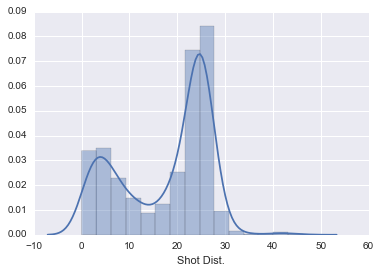

In [30]:
sns.distplot(transformed["Shot Dist."].apply(lambda x: float(x)))


In [31]:
transformed_combined["Def Dist."] = transformed_combined["Def Dist."].apply(lambda x: float(x))
a = transformed_combined[transformed_combined["Def Dist."] < 2]
print float((a["SHOT_MADE_FLAG"].sum()))/(a.shape[0]), a.shape[0]

a = transformed_combined[(transformed_combined["Def Dist."] >= 2) & (transformed_combined["Def Dist."]< 3)]
print float((a["SHOT_MADE_FLAG"].sum()))/(a.shape[0]),a.shape[0]

a = transformed_combined[(transformed_combined["Def Dist."] >= 3) & (transformed_combined["Def Dist."]< 4)]
print float((a["SHOT_MADE_FLAG"].sum()))/(a.shape[0]),a.shape[0]

a = transformed_combined[(transformed_combined["Def Dist."] >= 4) & (transformed_combined["Def Dist."]< 6)]
print float((a["SHOT_MADE_FLAG"].sum()))/(a.shape[0]),a.shape[0]


a = transformed_combined[(transformed_combined["Def Dist."] >= 6) & (transformed_combined["Def Dist."]< 8)]
print float((a["SHOT_MADE_FLAG"].sum()))/(a.shape[0]),a.shape[0]

a = transformed_combined[(transformed_combined["Def Dist."] >= 8) & (transformed_combined["Def Dist."]< 10)]
print float((a["SHOT_MADE_FLAG"].sum()))/(a.shape[0]),a.shape[0]

a = transformed_combined[(transformed_combined["Def Dist."]>=10)]
print float((a["SHOT_MADE_FLAG"].sum()))/(a.shape[0]),a.shape[0]


0.447204968944 161
0.528037383178 214
0.479245283019 265
0.479518072289 415
0.510752688172 186
0.509803921569 51
0.428571428571 49


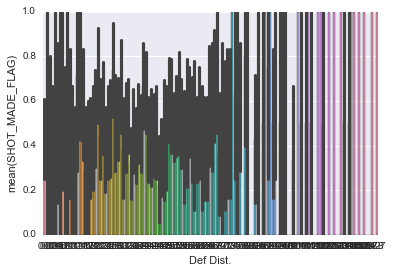

In [32]:
sns.barplot(x= "Def Dist.", y= "SHOT_MADE_FLAG", data =transformed_combined)

In [33]:
api_df["ACTION_TYPE"].value_counts()

Jump Shot                         561
Pullup Jump shot                  260
Step Back Jump shot               102
Driving Layup Shot                 96
Layup Shot                         65
Floating Jump shot                 45
Driving Finger Roll Layup Shot     38
Driving Reverse Layup Shot         30
Running Jump Shot                  23
Running Bank shot                  21
Reverse Layup Shot                 18
Driving Jump shot                  12
Jump Bank Shot                     11
Running Layup Shot                  8
Turnaround Jump Shot                8
Fadeaway Jump Shot                  7
Turnaround Bank shot                6
Driving Bank shot                   5
Turnaround Fadeaway shot            4
Pullup Bank shot                    4
Finger Roll Layup Shot              4
Running Finger Roll Layup Shot      3
Putback Layup Shot                  2
Driving Slam Dunk Shot              2
Turnaround Hook Shot                1
Running Hook Shot                   1
Fadeaway Ban

In [34]:
api_df["SHOT_TYPE"].value_counts()

2PT Field Goal    695
3PT Field Goal    646
Name: SHOT_TYPE, dtype: int64

In [35]:
api_df["SHOT_ZONE_BASIC"].value_counts()

Above the Break 3        557
Mid-Range                285
Restricted Area          284
In The Paint (Non-RA)    126
Right Corner 3            44
Left Corner 3             38
Backcourt                  7
Name: SHOT_ZONE_BASIC, dtype: int64

In [36]:
api_df["SHOT_ZONE_AREA"].value_counts()

Center(C)                603
Right Side Center(RC)    280
Left Side Center(LC)     245
Left Side(L)             107
Right Side(R)             98
Back Court(BC)             8
Name: SHOT_ZONE_AREA, dtype: int64

In [37]:
api_df["SHOT_ZONE_RANGE"].value_counts()

24+ ft.            638
Less Than 8 ft.    351
16-24 ft.          218
8-16 ft.           126
Back Court Shot      8
Name: SHOT_ZONE_RANGE, dtype: int64